In [17]:
import bokeh
from bokeh.charts import Scatter, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure,show
from bokeh.resources import CDN
from bokeh.embed import file_html
output_notebook()

import sys
sys.path.append('/Users/jaredlorince/Downloads/tsne_python/')
import tsne
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist,squareform
from sklearn.metrics.pairwise import pairwise_distances
from urllib import unquote_plus
import scipy.io as sio

import seaborn
from seaborn import color_palette
colors = color_palette()

Loading BokehJS ...

In [1]:
# Generate all genre data for color mapping
if False:
    vocab_idx = {}
    for line in open('../GenreModeling/data/vocab_idx'):
        line = line.strip().split('\t')
        #vocab_idx[int(line[1])] = unquote_plus(line[0]).title()
        vocab_idx[int(line[1])] = line[0]
    gn_data = pd.read_table('/Users/jaredlorince/Dropbox/gracenote_song_data')
    artist_data = gn_data.groupby('gn_artist').apply(lambda df: df.iloc[0])
    genre_data = artist_data[['genre1','genre2','genre3']].reindex(pd.Series(vocab_idx.values())).reset_index()
    genre_data.to_csv("/Users/jaredlorince/git/MusicForaging/GenreModeling/data/gracenote_genre_data.csv",index=False)

In [6]:
# load saved genre data and the tSNE data (from Matlab) that we want to plot
genre_data = pd.read_csv("/Users/jaredlorince/git/MusicForaging/GenreModeling/data/gracenote_genre_data.csv")
Y = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/result_10000_nmf.mat')['result']

In [9]:

test = Y#[:1000]
genre_level='1'
genres = genre_data['genre'+genre_level].unique()

def get_color(genre):
    if genre is np.nan or genre=='other':
        genre = 'other/unknown'
    color = color_dict[genre]
    return genre,color

color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
       'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=9))).astype(int)]))
color_dict['other/unknown'] = '#000000'
colors = [get_color(g)[1] for g in genre_data['genre1'].values[:len(test)]]

raw_source = pd.DataFrame(dict(
    x=test[:,0],
    y=test[:,1],
    label=[unquote_plus(vocab_idx[i]) for i in range(len(test))],
    color=colors,
    genre = [get_color(g)[0] for g in genre_data['genre1'].values[:len(test)]]))

#raw_source.head()

,color,genre,label,x,y
0,#e41a1c,rock,the beatles,-29.578122,3.014788
1,#377eb8,alternative & punk,radiohead,-6.838255,1.687610
2,#377eb8,alternative & punk,muse,-4.468484,1.172417
3,#e41a1c,rock,pink floyd,-28.370972,4.859935
4,#e41a1c,rock,metallica,-30.800634,18.685001


In [7]:
bokeh.plotting.curdoc().clear()
saveit = False
from bokeh.models import Circle,BoxSelectTool, BoxZoomTool, LassoSelectTool,Text,HoverTool
from bokeh.plotting import ColumnDataSource
from collections import OrderedDict

TOOLS="box_zoom,pan,reset,box_select,wheel_zoom,help,hover"
p = figure(plot_width=600, plot_height=600,tools=TOOLS)#,x_range=(-10,10))

for genre in raw_source['genre'].unique():
    source = ColumnDataSource(raw_source[raw_source['genre']==genre])
    p.circle(x='x',y='y',size=8,source=source,color='color',selection_color='color',nonselection_color='color',alpha=0.5,legend=genre)
    p.text(x='x',y='y',text='label',source=source,alpha=0.,selection_text_alpha=.55,nonselection_text_alpha=0.)

hover = p.select(dict(type=HoverTool))
hover.tooltips = '@label'

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.yaxis.visible = None
p.xaxis.visible = None

if saveit:
    html = file_html(p, CDN, "artist feature space visualization")
    with open('/Users/jaredlorince/Downloads/test.html','w') as f:
        f.write(html)
show(p)


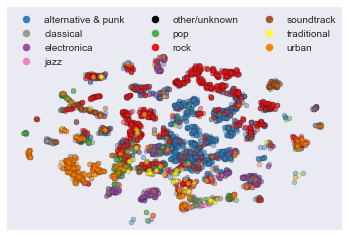

In [39]:
### static versions of tsne viz for paper

from matplotlib import pyplot as plt
%matplotlib inline


import scipy.io as sio

for f in ('result_10000',):#,'result_10000_nmf','result_10000_userlda_vanilla'):

    Y = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/{}.mat'.format(f))['result']

    test = Y[:5000]
    genre_data = genre_data[:len(test)]


    def get_color(genre):
        if genre is np.nan or genre=='other':
            genre = 'other/unknown'
        color = color_dict[genre]
        return genre,color

    #color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
    #       'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.array(color_palette("Set1",n_colors=9))]))
    color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
           'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=9))).astype(int)]))
    color_dict['other/unknown'] = '#000000'
    #color_dict['other'] = (0.,0.,0.)
    #color_dict[np.nan] = (0.,0.,0.)
    colors = np.array([get_color(g)[1] for g in genre_data['genre1'].values[:len(test)]])


    fig,ax = plt.subplots(1,1,figsize=(6,4))
    for g in sorted(color_dict.keys()):
        if g == 'other/unkonwn':
            indices = genre_data[(genre_data['genre1'].isin([np.nan,'other','unknown']))]['genre1'].index.values
        else:
            indices = genre_data[genre_data['genre1']==g]['genre1'].index.values
        ax.scatter(test[indices,0],test[indices,1],c=color_dict[g],s=25,alpha=0.45)
        legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=15, label=g, c=color_dict[g])

    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(-145,145)
    ax.set_ylim(-130,185)
    #ax.legend(bbox_to_anchor=(1.35,1))
    # handles, labels = ax.get_legend_handles_labels()
    # for h in handles:
    #     h.set_alpha(1.)
    #legend = ax.legend(handles,labels,loc='upper left',ncol=3)#,fancybox=True,framealpha=0.5,frameon=True)
    ax.legend(loc='upper left',ncol=3)
    #legend.get_frame().set_color('gray')



    fig.savefig('/Users/jaredlorince/Desktop/test.pdf',bbox_inches='tight')